<a href="https://colab.research.google.com/github/Triniti0/klasifikasi-penyakit-daun-cabai/blob/main/Eksperimen_Optimasi_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inisialisasi

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
import numpy as np
import os
import time
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau

Mounted at /content/drive


In [2]:
EXPERIMENT_NAME = "Progressive_FineTuning"
BASE_SAVE_DIR = "/content/drive/MyDrive/Seminar Hasil/Experiments"

SAVE_DIR = os.path.join(BASE_SAVE_DIR, EXPERIMENT_NAME)
os.makedirs(SAVE_DIR, exist_ok=True)

RESULTS_FILE = os.path.join(SAVE_DIR, "grid_results.csv")
BEST_MODEL_INFO = os.path.join(SAVE_DIR, "best_model_info.json")

# Load Dataset

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def load_dataset():
    train_ds = tf.keras.utils.image_dataset_from_directory(
        "/content/drive/MyDrive/Seminar Hasil/dataset_processed/train",
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        "/content/drive/MyDrive/Seminar Hasil/dataset_processed/val",
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE
    )

    test_ds = tf.keras.utils.image_dataset_from_directory(
        "/content/drive/MyDrive/Seminar Hasil/dataset_processed/test",
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    class_names = train_ds.class_names

    def preprocess(x, y):
        return preprocess_input(x), y

    train_ds = train_ds.map(preprocess).prefetch(AUTOTUNE)
    val_ds = val_ds.map(preprocess).prefetch(AUTOTUNE)
    test_ds = test_ds.map(preprocess).prefetch(AUTOTUNE)

    return train_ds, val_ds, test_ds, class_names

# Model Progressive Fine-Tuning (FUNGSI FREEZE DINAMIS)

In [4]:
def build_base_model(num_classes, dropout_rate=0.3):

    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model, base_model

FREEZE STRATEGY PER STAGE

In [5]:
def apply_freeze(base_model, stage):

    total = len(base_model.layers)

    if stage == 1:
        for layer in base_model.layers:
            layer.trainable = False

    elif stage == 2:
        freeze_until = int(total * 0.7)
        for layer in base_model.layers[:freeze_until]:
            layer.trainable = False
        for layer in base_model.layers[freeze_until:]:
            layer.trainable = True

    elif stage == 3:
        freeze_until = int(total * 0.5)
        for layer in base_model.layers[:freeze_until]:
            layer.trainable = False
        for layer in base_model.layers[freeze_until:]:
            layer.trainable = True

# Pelatihan Model (Multi Stage)

In [6]:
#Konfigurasi parameter
epoch_grid = [20, 30]
learning_rates = [1e-3, 1e-4, 1e-5]

In [7]:
#resume check
if os.path.exists(RESULTS_FILE):
    results_df = pd.read_csv(RESULTS_FILE)
    completed = set(results_df["Config_ID"])
    best_val_acc = results_df["Val Accuracy"].max()
else:
    results_df = pd.DataFrame()
    completed = set()
    best_val_acc = 0

In [8]:
#pelatihan model
train_ds, val_ds, test_ds, class_names = load_dataset()
num_classes = len(class_names)

for epochs_per_stage in epoch_grid:

    cid = f"EPOCHS{epochs_per_stage}"

    if cid in completed:
        print("Skip:", cid)
        continue

    print("\nRunning Progressive with", epochs_per_stage, "epochs/stage")

    model, base_model = build_base_model(num_classes)

    history_all = {
        "accuracy": [],
        "val_accuracy": [],
        "loss": [],
        "val_loss": []
    }

    start_time = time.time()

    for stage in [1, 2, 3]:

        apply_freeze(base_model, stage)

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rates[stage-1]),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        callbacks = [
            ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)
        ]

        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs_per_stage,
            callbacks=callbacks,
            verbose=1
        )

        for k in history_all:
            history_all[k].extend(history.history[k])

    training_time = time.time() - start_time
    val_loss, val_acc = model.evaluate(val_ds, verbose=0)

    if val_acc > best_val_acc:
        best_val_acc = val_acc

        model_filename = f"Best_Model_{EXPERIMENT_NAME}_{cid}.h5"
        model_path = os.path.join(SAVE_DIR, model_filename)
        model.save(model_path)

        best_metadata = {
            "Experiment_Name": EXPERIMENT_NAME,
            "Config_ID": cid,
            "Epoch per Stage": epochs_per_stage,
            "Validation Accuracy": float(val_acc),
            "Model Path": model_path
        }

        with open(BEST_MODEL_INFO, "w") as f:
            json.dump(best_metadata, f, indent=4)

        print("New Best Model Saved:", model_filename)

    new_row = {
        "Config_ID": cid,
        "Epoch per Stage": epochs_per_stage,
        "Val Accuracy": val_acc,
        "Training Time": training_time
    }

    results_df = pd.concat([results_df, pd.DataFrame([new_row])])
    results_df.to_csv(RESULTS_FILE, index=False)

Found 11704 files belonging to 8 classes.
Found 617 files belonging to 8 classes.
Found 620 files belonging to 8 classes.

Running Progressive with 20 epochs/stage
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 285s 726ms/step - accuracy: 0.8421 - loss: 0.4742 - val_accuracy: 0.9741 - val_loss: 0.0897 - learning_rate: 0.0010
Epoch 2/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9813 - loss: 0.0631 - val_accuracy: 0.9822 - val_loss: 0.0681 - learning_rate: 0.0010
Epoch 3/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9892 - loss: 0.0393 - val_accuracy: 0.9757 - val_loss: 0.0698 - learning_rate: 0.0010
Epoch 4/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9922 - loss: 0.0261 - val_accuracy: 0.9789 - val_loss: 0.0607 - learning_rate: 0.0010
Epoch 5/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9935 - loss: 0.0212 - val_accuracy: 0.9806 - val_loss: 0.0738 - learning_rate: 0.0010
Epoch 6/20
366/

New Best Model Saved: Best_Model_Progressive_FineTuning_EPOCHS20.h5

Running Progressive with 30 epochs/stage
Epoch 1/30
366/366 ━━━━━━━━━━━━━━━━━━━━ 36s 75ms/step - accuracy: 0.8151 - loss: 0.5494 - val_accuracy: 0.9773 - val_loss: 0.0902 - learning_rate: 0.0010
Epoch 2/30
366/366 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9776 - loss: 0.0681 - val_accuracy: 0.9789 - val_loss: 0.0702 - learning_rate: 0.0010
Epoch 3/30
366/366 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9891 - loss: 0.0359 - val_accuracy: 0.9741 - val_loss: 0.0903 - learning_rate: 0.0010
Epoch 4/30
366/366 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9897 - loss: 0.0305 - val_accuracy: 0.9822 - val_loss: 0.0522 - learning_rate: 0.0010
Epoch 5/30
366/366 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9911 - loss: 0.0247 - val_accuracy: 0.9854 - val_loss: 0.0591 - learning_rate: 0.0010
Epoch 6/30
366/366 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9950 - loss: 0.0187 - val_accuracy: 0.9854 - val_los

# Evaluasi

In [9]:
with open(BEST_MODEL_INFO, "r") as f:
    best_info = json.load(f)

print("\n===== BEST MODEL INFO =====")
for k, v in best_info.items():
    print(k, ":", v)

best_model = tf.keras.models.load_model(best_info["Model Path"])


===== BEST MODEL INFO =====
Experiment_Name : Progressive_FineTuning
Config_ID : EPOCHS20
Epoch per Stage : 20
Validation Accuracy : 0.9886547923088074
Model Path : /content/drive/MyDrive/Seminar Hasil/Experiments/Progressive_FineTuning/Best_Model_Progressive_FineTuning_EPOCHS20.h5


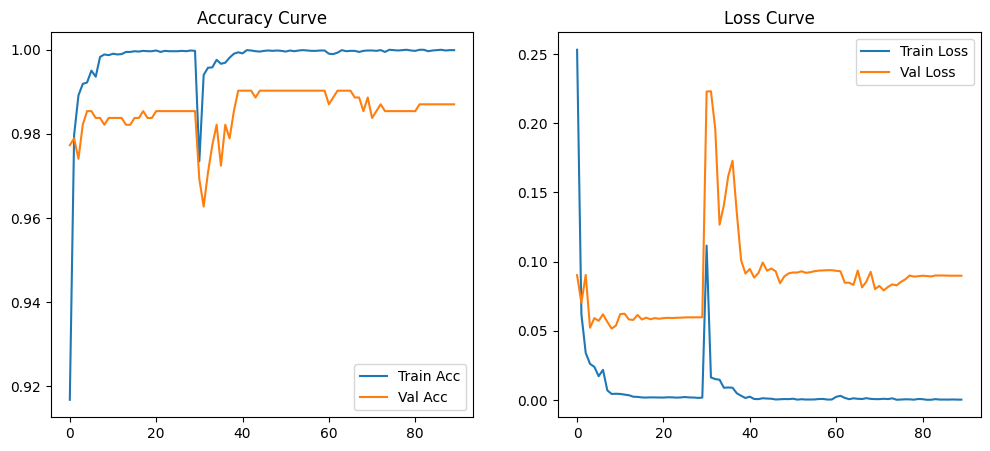

In [10]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_all["accuracy"], label="Train Acc")
plt.plot(history_all["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy Curve")

plt.subplot(1,2,2)
plt.plot(history_all["loss"], label="Train Loss")
plt.plot(history_all["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.show()

In [18]:
train_acc = history_all["accuracy"][-1]
val_acc = history_all["val_accuracy"][-1]
# Calculate test_acc separately by evaluating the best model on the test dataset
_, test_acc = best_model.evaluate(test_ds, verbose=0)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

if train_acc - val_acc > 0.10:
    print("⚠ Overfitting detected")
elif val_acc > train_acc:
    print("⚠ Possible underfitting")
else:
    print("✔ Model stable")

Train Accuracy: 0.9999
Validation Accuracy: 0.9870
Test Accuracy: 0.9952
✔ Model stable


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
                      precision    recall  f1-score   support

         Anthracnose       1.00      1.00      1.00        25
      Bacterial Spot       0.92      0.96      0.94        24
Cercospora Leaf Spot       1.00      0.93      0.96  

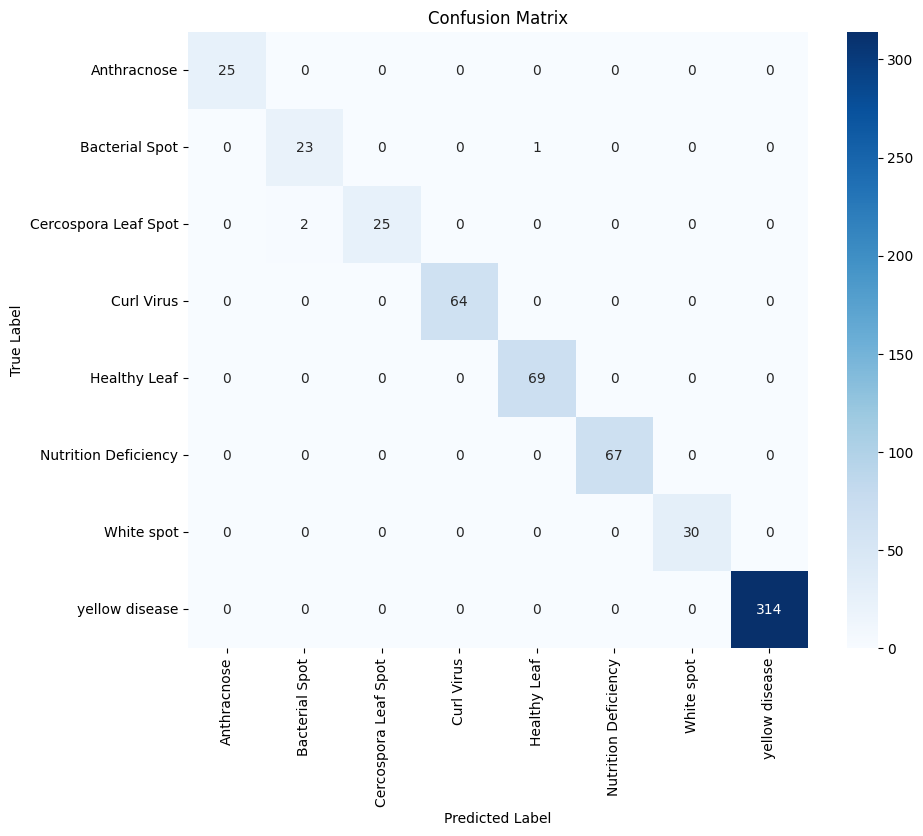

In [13]:
#confusion matrix
import seaborn as sns

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = best_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [14]:
#waktu inferensi
sample = next(iter(test_ds))[0]

start = time.time()
_ = best_model.predict(sample)
inference_time = (time.time() - start) / len(sample)

print("Inference Time per Image:", inference_time)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Inference Time per Image: 0.0033425241708755493


In [15]:
#ukuran file model
size_mb = os.path.getsize(best_info["Model Path"]) / (1024*1024)
print("Model Size (MB):", size_mb)

Model Size (MB): 26.83129119873047
